In [1]:
import datastore

import pandas as pd
import matplotlib.pyplot as plt

spot = datastore.getSpotPrice()

total_consumption_production = datastore.getTotalConsumptionProduction()

production_se1_mwh = datastore.getAllSE1ProductionMWh() 
production_se2_mwh = datastore.getAllSE2ProductionMWh()
production_se3_mwh = datastore.getAllSE3ProductionMWh()
production_se4_mwh = datastore.getAllSE4ProductionMWh()

transTo = datastore.getTransmissionCapTo()
transFrom = datastore.getTransmissionCapFrom()

# netFlow = datastore.getNetFlow() # Too many missing values
flow = datastore.getFlow()

capTo = datastore.getFlowCapacityTo()
capFrom = datastore.getFlowCapacityFrom()

exchangeFrom = datastore.getExchangeFrom()
exchangeTo = datastore.getExchangeTo() 

turnOver = datastore.getTurnover()

temp_pen = datastore.getDailyWeather() # DAILY celsius
wind_velocities = datastore.getHourlyWindVelocity() # m/s
hydroReservoirs = datastore.getWeeklyHydroReservs() # GWh

Missing values in Index(['spotPrice'], dtype='object') : 6
Missing values in Index(['ConsumptionGWh', 'ProductionGWh'], dtype='object') : 14
Missing values in Index(['waterSE1(MWh)', 'windSE1(MWh)', 'trmSE1MWh'], dtype='object') : 46
Missing values in Index(['waterSE2(MWh)', 'windSE2(MWh)', 'solSE2MWh', 'trmSE2MWh', 'OthSE2MWh'], dtype='object') : 144
Missing values in Index(['waterSE3(MWh)', 'windSE3(MWh)', 'nucSE3(MWh)', 'solSE3MWh',
       'trmSE3MWh', 'OthSE3MWh'],
      dtype='object') : 139
Missing values in Index(['waterSE4(MWh)', 'windSE4(MWh)', 'solSE4MWh', 'trmSE4MWh', 'OthSE4MWh'], dtype='object') : 155
Missing values in Index(['TDK1SE3', 'TNO1SE3', 'TSE2SE3', 'TF1SE3', 'TSE4SE3'], dtype='object') : 0
Missing values in Index(['TSE3DK1', 'TSE3NO1', 'TSE3SE2', 'TSE3F1', 'TSE3SE4'], dtype='object') : 0
Missing values in Index(['F_LOWSE2SE3', 'F_LOWSE3FI', 'F_LOWSE3SE4'], dtype='object') : 6289
Missing values in Index(['C_SE4SE3', 'C_DK1SE3', 'C_FISE3', 'C_NO1SE3', 'C_SE2SE3'], 

In [2]:
import calendar_features as cf

dataset = pd.concat([spot, total_consumption_production,
                     production_se1_mwh, production_se2_mwh, production_se3_mwh, production_se4_mwh, 
                     transTo, transFrom, 
                     flow, capTo, capFrom, exchangeFrom, exchangeTo,
                     temp_pen, wind_velocities, hydroReservoirs, turnOver], axis=1)

dataset.interpolate(method = 'linear', limit_direction = 'forward', inplace=True, axis=0)

# daylight_features = cf.daylight_extractor(dataset)
holiday_features = cf.get_holidays(dataset)
dataset = cf.calendar_transformer(dataset)

dataset = pd.concat([dataset, holiday_features], axis=1)
dataset = pd.get_dummies(dataset, columns=["year", "month", "day_of_week", "hour"])

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54024 entries, 2018-01-01 00:00:00 to 2024-02-29 23:00:00
Columns: 113 entries, spotPrice to hour_23
dtypes: float64(61), int32(1), int64(1), uint8(50)
memory usage: 28.7 MB


In [3]:
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler

train_split = '2021-12-31 23:00:00'
val_split = '2022-12-31 23:00:00'
test_split = '2024-02-29 23:00:00'

train_split_index = dataset.index.get_loc(train_split)
val_split_index = dataset.index.get_loc(val_split)
test_split_index = dataset.index.get_loc(test_split)

features = dataset.drop('spotPrice', axis=1)
target = dataset['spotPrice'].to_frame()

past_covariates = TimeSeries.from_dataframe(features)
target_series = TimeSeries.from_dataframe(target)

past_covariates_scaler, target_scaler = Scaler(), Scaler()

past_covariates_scaled = past_covariates_scaler.fit_transform(past_covariates)
target_scaled = target_scaler.fit_transform(target_series)

target_train, target_val, target_test = target_scaled[:train_split_index], target_scaled[train_split_index:val_split_index], target_scaled[val_split_index:test_split_index]
past_covariates_train, past_covariates_val, past_covariates_test = past_covariates_scaled[:train_split_index], past_covariates_scaled[train_split_index:val_split_index], past_covariates_scaled[val_split_index:test_split_index]

past_covariates = concatenate([past_covariates_train, past_covariates_val, past_covariates_test])


In [43]:
from darts.models import BlockRNNModel, RNNModel
from darts.utils.callbacks import TFMProgressBar
import torch
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


my_stopper = EarlyStopping(
    monitor="val_loss",
    patience= 5,
    min_delta = 0.05,
    mode='min',
)

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": 'auto',
            "callbacks": [TFMProgressBar(enable_train_bar_only=True), my_stopper],
        }
    }

INPUT = 24 * 5 * 2
OUTPUT = 24*5
EPOCHS = 15
HIDDEN_DIM = 32
LOSS_FN = torch.nn.L1Loss()
METRICS = SymmetricMeanAbsolutePercentageError()
BATCH_SIZE = 32
N_LAYERS = 2

DROPOUT = 0.3

model = BlockRNNModel(
    model='LSTM',
    input_chunk_length = INPUT,
    output_chunk_length = OUTPUT,
    
    random_state=42,
    
    n_epochs= EPOCHS, 
    hidden_dim= HIDDEN_DIM,
    
    loss_fn = LOSS_FN,
    torch_metrics = METRICS,
    
    batch_size = BATCH_SIZE,
    
    n_rnn_layers = N_LAYERS,
    
    dropout = DROPOUT,
    
    **generate_torch_kwargs()
)

model_2 = RNNModel(
    model = "LSTM",
    hidden_dim= HIDDEN_DIM,
    batch_size = BATCH_SIZE,
    n_epochs = EPOCHS,
    random_state = 0,
    n_rnn_layers = 1, 
    training_length = INPUT + OUTPUT,
    input_chunk_length = INPUT,
    **generate_torch_kwargs()
    
)



In [44]:
model.fit(
    series = [target_train], #TARGET
    val_series = [target_val],
    past_covariates = [past_covariates], # ALL PAST COVARIATES
    val_past_covariates = [past_covariates], 
    
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | L1Loss           | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 27.3 K
4 | fc            | Sequential       | 4.0 K 
---------------------------------------------------
31.2 K    Trainable params
0         Non-trainable params
31.2 K    Total params
0.125     Total estimated model params size (MB)
c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\core\module.py:491: You called `self.log('val_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Training: 0it [00:00, ?it/s]

c:\Users\drami\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\core\module.py:491: You called `self.log('train_SymmetricMeanAbsolutePercentageError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


BlockRNNModel(model=LSTM, hidden_dim=32, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.3, input_chunk_length=240, output_chunk_length=120, random_state=42, n_epochs=15, loss_fn=L1Loss(), torch_metrics=SymmetricMeanAbsolutePercentageError(), batch_size=32, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x0000016311DA3580>, <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000016311DA35E0>]})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RMSE = 0.04111428588114303
SMAPE = 23.926952406236143
MAE = 0.03119398436222851


<Axes: xlabel='time'>

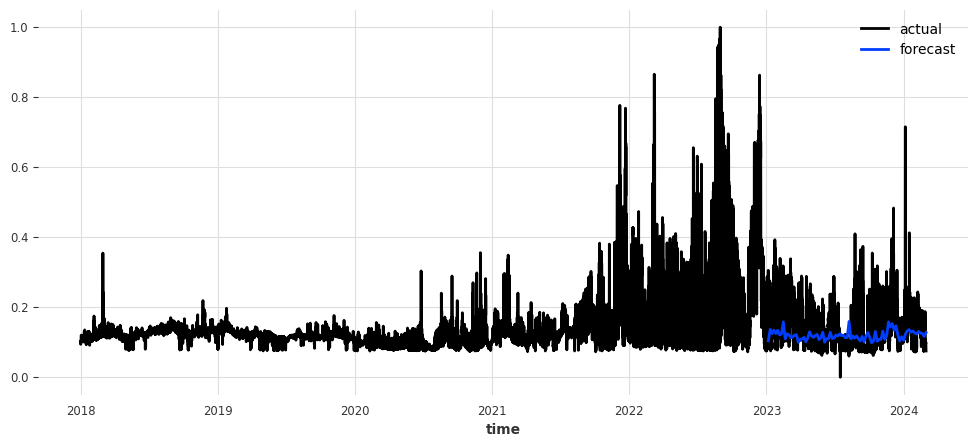

In [45]:
from darts.metrics import smape, mae, rmse

backtest = model.historical_forecasts(target_scaled,
                                      past_covariates = past_covariates,
                                      start = target_test.start_time(),
                                      forecast_horizon = OUTPUT,
                                      stride = OUTPUT,
                                      retrain = False,
                                      verbose = True)

backtest = concatenate(backtest)

print('RMSE = {}'.format(rmse(target_test, backtest)))
print('SMAPE = {}'.format(smape(target_test, backtest)))
print('MAE = {}'.format(mae(target_test, backtest)))


plt.figure(figsize=(12,5))
y_test.plot(label='actual')
backtest.plot(label='forecast')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


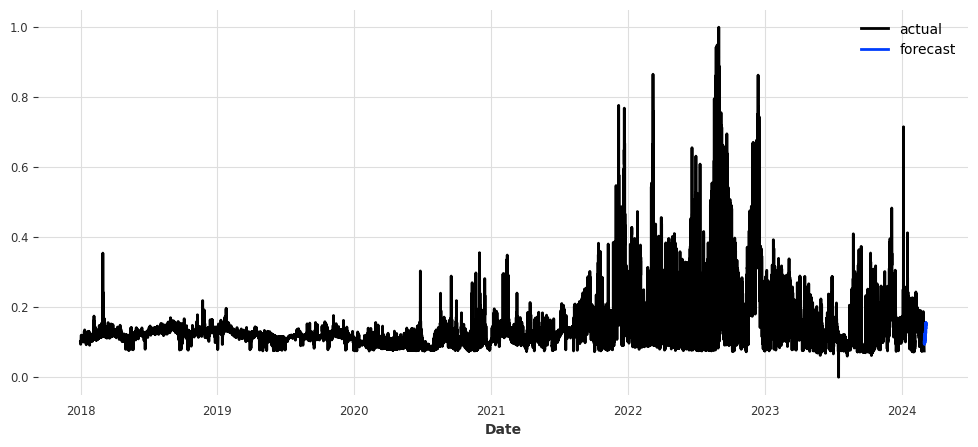

In [48]:
pred = model.predict(n = OUTPUT, series = target_test, past_covariates = past_covariates , verbose = 1, mc_dropout=True)

plt.figure(figsize=(12,5))
target_scaled.plot(label='actual')

pred.plot(label='forecast')

plt.legend()
